In [31]:
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [32]:
# Set the ticker and period
ticker = 'AMZN'
period1 = int(time.mktime(datetime.datetime(2022, 1, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime.now().timetuple()))
interval = '1d'

In [33]:
# Fetch the data
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
df = pd.read_csv(query_string)

In [34]:
# Convert Date column to datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

In [35]:
df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')

In [36]:
# Adjust the initial date to be 101 days after the first date
dt = df.index[101]
curr = (datetime.datetime.now() - datetime.timedelta(days=4)).strftime('%Y-%m-%d')

In [37]:
# Adjust the window size to 100 days
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=100):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

# Get the windowed dataframe
windowed_df = df_to_windowed_df(df, dt.strftime('%Y-%m-%d'), curr, n=100)
windowed_df

C:\Users\acer\AppData\Local\Temp\ipykernel_19508\3385289352.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df[f'Target-{n-i}'] = X[:, i]
C:\Users\acer\AppData\Local\Temp\ipykernel_19508\3385289352.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret_df['Target'] = Y


,Target Date,Target-100,Target-99,Target-98,Target-97,Target-96,Target-95,Target-94,Target-93,Target-92,...,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2022-05-27,167.522003,164.356995,163.253998,162.554001,161.485992,165.362000,165.207001,161.214005,162.138000,...,110.810501,115.368500,107.112503,107.319000,107.591003,107.556999,104.099998,106.775002,111.077499,115.146500
1,2022-05-31,164.356995,163.253998,162.554001,161.485992,165.362000,165.207001,161.214005,162.138000,158.917496,...,115.368500,107.112503,107.319000,107.591003,107.556999,104.099998,106.775002,111.077499,115.146500,120.209503
2,2022-06-01,163.253998,162.554001,161.485992,165.362000,165.207001,161.214005,162.138000,158.917496,156.298996,...,107.112503,107.319000,107.591003,107.556999,104.099998,106.775002,111.077499,115.146500,120.209503,121.683998
3,2022-06-02,162.554001,161.485992,165.362000,165.207001,161.214005,162.138000,158.917496,156.298996,151.667496,...,107.319000,107.591003,107.556999,104.099998,106.775002,111.077499,115.146500,120.209503,121.683998,125.511002
4,2022-06-03,161.485992,165.362000,165.207001,161.214005,162.138000,158.917496,156.298996,151.667496,142.643005,...,107.591003,107.556999,104.099998,106.775002,111.077499,115.146500,120.209503,121.683998,125.511002,122.349998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,2024-05-20,153.410004,153.339996,153.380005,151.940002,149.929993,148.470001,144.570007,145.240005,149.100006,...,188.759995,188.000000,189.500000,187.479996,186.570007,187.070007,185.990005,183.630005,184.699997,183.539993
497,2024-05-21,153.339996,153.380005,151.940002,149.929993,148.470001,144.570007,145.240005,149.100006,151.369995,...,188.000000,189.500000,187.479996,186.570007,187.070007,185.990005,183.630005,184.699997,183.539993,183.149994
498,2024-05-22,153.380005,151.940002,149.929993,148.470001,144.570007,145.240005,149.100006,151.369995,153.729996,...,189.500000,187.479996,186.570007,187.070007,185.990005,183.630005,184.699997,183.539993,183.149994,183.130005
499,2024-05-23,151.940002,149.929993,148.470001,144.570007,145.240005,149.100006,151.369995,153.729996,155.179993,...,187.479996,186.570007,187.070007,185.990005,183.630005,184.699997,183.539993,183.149994,183.130005,181.050003


In [38]:
# Convert windowed dataframe to dates, X, and y
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1]))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

((501,), (501, 100), (501,))

In [39]:
# Split the data into train, validation, and test sets
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

In [40]:
# Define and train the model
model = keras.Sequential([
    keras.layers.Input((100, 1)),
    tf.keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
13/13 [==============================] - 15s 414ms/step - loss: 14242.4883 - mean_absolute_error: 117.8924 - val_loss: 26868.3906 - val_mean_absolute_error: 163.6032
Epoch 2/100
13/13 [==============================] - 1s 91ms/step - loss: 13915.2002 - mean_absolute_error: 116.4939 - val_loss: 26295.3379 - val_mean_absolute_error: 161.8423
Epoch 3/100
13/13 [==============================] - 1s 86ms/step - loss: 13313.1299 - mean_absolute_error: 113.8631 - val_loss: 25049.3008 - val_mean_absolute_error: 157.9448
Epoch 4/100
13/13 [==============================] - 2s 161ms/step - loss: 11965.8203 - mean_absolute_error: 107.7669 - val_loss: 22347.1133 - val_mean_absolute_error: 149.1454
Epoch 5/100
13/13 [==============================] - 2s 121ms/step - loss: 9534.2559 - mean_absolute_error: 95.6813 - val_loss: 18015.4023 - val_mean_absolute_error: 133.8279
Epoch 6/100
13/13 [==============================] - 1s 116ms/step - loss: 6019.6064 - mean_absolute_error: 74.8195 - 

13/13 [==============================] - 1s 17ms/step


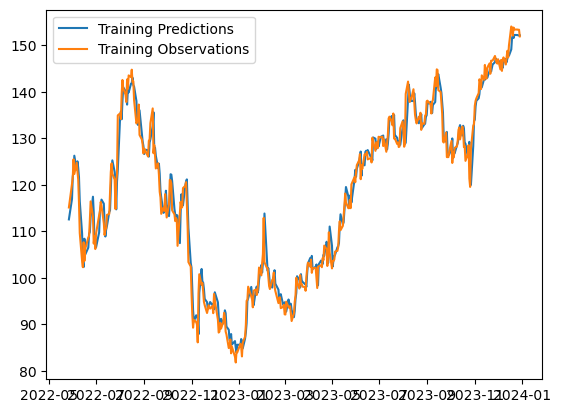

In [41]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 26ms/step


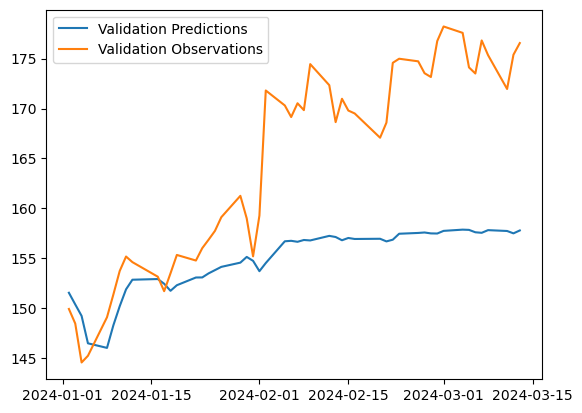

In [42]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 20ms/step


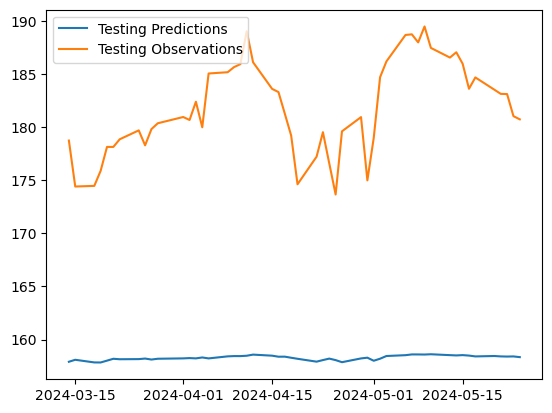

In [43]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [44]:
dates_test

array([Timestamp('2024-03-14 00:00:00'), Timestamp('2024-03-15 00:00:00'),
       Timestamp('2024-03-18 00:00:00'), Timestamp('2024-03-19 00:00:00'),
       Timestamp('2024-03-20 00:00:00'), Timestamp('2024-03-21 00:00:00'),
       Timestamp('2024-03-22 00:00:00'), Timestamp('2024-03-25 00:00:00'),
       Timestamp('2024-03-26 00:00:00'), Timestamp('2024-03-27 00:00:00'),
       Timestamp('2024-03-28 00:00:00'), Timestamp('2024-04-01 00:00:00'),
       Timestamp('2024-04-02 00:00:00'), Timestamp('2024-04-03 00:00:00'),
       Timestamp('2024-04-04 00:00:00'), Timestamp('2024-04-05 00:00:00'),
       Timestamp('2024-04-08 00:00:00'), Timestamp('2024-04-09 00:00:00'),
       Timestamp('2024-04-10 00:00:00'), Timestamp('2024-04-11 00:00:00'),
       Timestamp('2024-04-12 00:00:00'), Timestamp('2024-04-15 00:00:00'),
       Timestamp('2024-04-16 00:00:00'), Timestamp('2024-04-17 00:00:00'),
       Timestamp('2024-04-18 00:00:00'), Timestamp('2024-04-19 00:00:00'),
       Timestamp('2024-04

In [45]:
test_predictions

array([157.90686, 158.0932 , 157.84457, 157.83948, 158.01295, 158.18814,
       158.14478, 158.15665, 158.20886, 158.1165 , 158.19125, 158.22519,
       158.25298, 158.22551, 158.31186, 158.2237 , 158.41516, 158.44159,
       158.44034, 158.47464, 158.5799 , 158.48058, 158.38313, 158.38742,
       158.28494, 158.18773, 157.91714, 158.06621, 158.20508, 158.06259,
       157.86682, 158.22165, 158.2911 , 158.00266, 158.19496, 158.44925,
       158.52725, 158.59827, 158.59616, 158.58798, 158.61386, 158.53046,
       158.50414, 158.53316, 158.48946, 158.41124, 158.44868, 158.41159,
       158.39755, 158.40947, 158.34314], dtype=float32)

In [46]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,167.550003,170.703506,166.160507,170.404495,170.404495,63520000
2022-01-04,170.438004,171.399994,166.349503,167.522003,167.522003,70726000
2022-01-05,166.882996,167.126495,164.356995,164.356995,164.356995,64302000
2022-01-06,163.450500,164.800003,161.936996,163.253998,163.253998,51958000
2022-01-07,163.839005,165.243500,162.031006,162.554001,162.554001,46606000
...,...,...,...,...,...,...
2024-05-21,182.300003,183.259995,180.750000,183.149994,183.149994,50839100
2024-05-22,183.880005,185.220001,181.970001,183.130005,183.130005,28148800
2024-05-23,183.660004,184.759995,180.080002,181.050003,181.050003,33670200


In [47]:
req = windowed_df.tail(3)
req['Target']

498    183.130005
499    181.050003
500    180.750000
Name: Target, dtype: float64

In [48]:
inp = tuple(req['Target'])

In [49]:
inp

(183.130005, 181.050003, 180.75)

In [50]:
npin = np.asarray(inp)
rs = npin.reshape(1, -1)
stk_pred = model.predict(rs)

1/1 [==============================] - 2s 2s/step


In [51]:
stk_pred

array([[132.28189]], dtype=float32)

In [52]:
today = float(stk_pred)

In [53]:
today

132.28189086914062

In [54]:
req1 = windowed_df.tail(2)
tom = list(req1['Target'])

In [55]:
tom = tom + [today,]

In [56]:
tom

[181.050003, 180.75, 132.28189086914062]

In [57]:
tom1 = tuple(tom)

In [58]:
tom1


(181.050003, 180.75, 132.28189086914062)

In [59]:
npin = np.asarray(tom1)
rs = npin.reshape(1, -1)
tom_pred = model.predict(rs)

1/1 [==============================] - 0s 88ms/step


In [60]:
tom_pred

array([[133.40898]], dtype=float32)